# Pytroch autodiff example

In [103]:
import torch

x = torch.tensor(5.0, requires_grad=True)
f = 2 * (x ** 2) + 5
gr, = torch.autograd.grad(f, x)
print(gr)  # This will print the derivative of f with respect to x

tensor(20.)


# Units lookups
kcal/(g * Å) in Å/(ps²) wolfram says: <br>

418.4 Å/ps^2 (ångströms per picosecond squared) <br>

maybe I should have used a unit package but I havent used one before


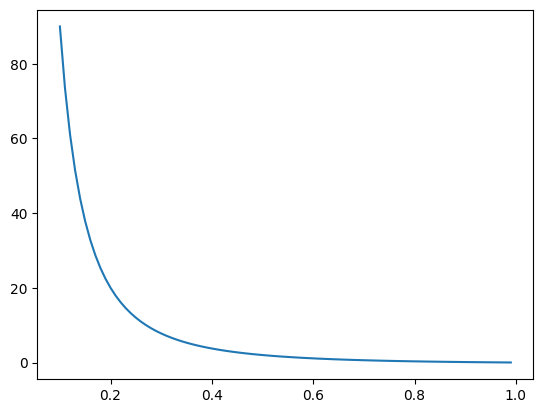

In [158]:
import matplotlib.pyplot as plt
import numpy as np

xx = np.arange(0.1, 1,0.01)  
yy = 1/(xx**2)-1/xx 

plt.plot(xx, yy)
plt.show()


# Reflection image
![reflection img](reflection_img.jpg)

In [182]:
from dataclasses import dataclass
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange

@dataclass
class Simulation_constants:
    """Holds simulation constants"""
    m: float = 39.9748 # g/mol , mass
    T: float = 300 # K , T
    sigma: float = 3.4 # A, particle size
    eps: float = 0.24 # kcal/mol interactions_strength
    # A box defined by 2 corners (xi,yi), (xf,yf)
    xi: float = 0 # A
    yi: float = 0 # A
    xf: float = 20 # A
    yf: float = 20 # A


class MD_simulation(ABC):
    def __init__(self,sim_cons,pos_file="intial_pos.csv",vel_file="intial_vel.csv"):
        self.positions = torch.from_numpy(np.genfromtxt(pos_file)) # A
        self.velocities  = torch.from_numpy(np.genfromtxt(vel_file)) # A/ps
        self.accelerations = torch.zeros_like(self.positions) # A/ps^2 has to be defined
        self.constants = sim_cons
        self.total_steps = 0  

        if self.positions.shape != self.velocities.shape:
            raise ValueError("Positions and velocities must have the same shape")

    @abstractmethod   
    def get_potential_energy(self):
        """Calculates the potential energy."""
        pass

    def get_kinetic_energy(self,debug =False):
        """Calculates the kinetic energy, 0.5*sum(m v**2)."""
        v2 = torch.einsum( "p c , p c -> p", self.velocities, self.velocities) # A^2/ps^2
        if debug:
            print(f"v2: \n {v2.detach().numpy()}")
        return 0.5*self.constants.m*torch.einsum("p ->", v2) # g A^2/(ps^2 mol)


    def get_force(self):
        """Calculates the force as the negative gradient of the potential energy."""
        positions = self.positions.detach().requires_grad_(True)
        energy = self.get_potential_energy(positions) 
        forces, = torch.autograd.grad(energy, positions)
        return -forces

    def get_acceleration(self):
        """F = ma and unit stuff."""
        a = self.get_force()/self.constants.m #kcal/(mol * A * (g/mol)) = kcal/(g *A) = 418.4 A/(ps^2)
        a_unit_factor_kcal_per_gA_to_A_per_ps2 = 418.4 # see units lookup
        return a *a_unit_factor_kcal_per_gA_to_A_per_ps2

    @abstractmethod   
    def step(self):
        """Performs a single step of the simulation."""
        pass


    def step_reflect(self, debug=False, reflect_log=False):
        """Reflects particles that have crossed the boundary."""

        # see img, calculating difference between point and corners with broadcasting
        diff_to_axis = rearrange(self.positions, "p c -> 1 p c") - torch.tensor([
            [[self.constants.xi, self.constants.yi]],
            [[self.constants.xf, self.constants.yf]]
        ]) # A

        # figures out that the point is at correct side of the corner
        diff_to_axis[0,:,:] = torch.min(diff_to_axis[0,:,:], torch.tensor([0]))
        diff_to_axis[1,:,:] = torch.max(diff_to_axis[1,:,:], torch.tensor([0]))

        # the adjustment is - diff *2 and are exclusive so can be summed
        pos_adj = - 2 * torch.einsum("h p c -> p c", diff_to_axis)

        # where an adjustment happens the velocity gets multiplied by -1
        vel_adj = torch.where(torch.abs(pos_adj) > 0, -1, 1)

        if reflect_log:
            adj = torch.einsum("p c -> p", torch.abs(pos_adj))
            amount_reflections = torch.einsum("p->", torch.where(adj > 0, 1, 0))
            if amount_reflections>0:
                print(f"amount of reflections: {amount_reflections}")

        if debug:
            print("Debug Information: Reflect Step")
            print("-" * 40)  # Separator for better readability
            print("Current Boundary Corners:")
            print(f"Bottom Left Corner: ({self.constants.xi}, {self.constants.yi})")
            print(f"Top Right Corner: ({self.constants.xf}, {self.constants.yf})")
            print("\nPosition Adjustments (pos_adj):")
            print(pos_adj)
            print("\nVelocity Adjustments (vel_adj):")
            print(vel_adj)
            print("-" * 40)  # Separator for clarity
            self.plt_points()

        # update positions and velocities
        self.positions = self.positions + pos_adj
        self.velocities = self.velocities * vel_adj

        if debug:
            self.plt_points()


    def plt_points(self):
        """Try it to see what is does, LLMs are great at writing plots."""
        pos = self.positions.detach().numpy()  # Positions
        vel = self.velocities.detach().numpy()  # Velocities
        acc = self.accelerations.detach().numpy()  # Accelerations

        plt.scatter(pos[:, 0], pos[:, 1], color='blue', label='Particles')  # Scatter plot for the points

        # Annotate each point with an identifier (e.g., index)
        for i, (x, y) in enumerate(pos):
            plt.annotate(f'{i}', (x, y), textcoords="offset points", xytext=(5, 5), ha='center')

            # Add arrows for velocities
            plt.arrow(x, y, vel[i, 0], vel[i, 1],
                    head_width=0.1, head_length=0.2,
                    fc='red', ec='red',
                    length_includes_head=True)  # Draw velocity vectors as arrows

            # Add arrows for accelerations
            plt.arrow(x, y, acc[i, 0], acc[i, 1],
                    head_width=0.1, head_length=0.2,
                    fc='green', ec='green',
                    length_includes_head=True)  # Draw acceleration vectors as arrows

        # Draw the box
        box_x = [self.constants.xi, self.constants.xf, self.constants.xf, self.constants.xi, self.constants.xi]
        box_y = [self.constants.yi, self.constants.yi, self.constants.yf, self.constants.yf, self.constants.yi]
        plt.plot(box_x, box_y, color='black', linestyle='--', label='Box')  # Draw the box

        # Create dummy artists for velocity and acceleration arrows in the legend
        plt.plot([], [], color='red', marker='o', linestyle='-', label='Velocities')
        plt.plot([], [], color='green', marker='o', linestyle='-', label='Accelerations')

        # Labels and limits
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        plt.xlim(self.constants.xi - 5, self.constants.xf + 5)
        plt.ylim(self.constants.yi - 5, self.constants.yf + 5)
        plt.grid(True)
        plt.legend()  # Add legend to distinguish the particles and boundary box
        plt.title('Particle Positions with Velocities and Accelerations')
        plt.show()




class MD_simulation_lj_vv(MD_simulation):
    """Implements the Lennard-Jones potential and Velocity Verlet integration step"""

    def __init__(self,sim_cons,pos_file="initial_pos.csv",vel_file="initial_vel.csv"):
        MD_simulation.__init__(self,sim_cons,pos_file,vel_file)
        self.accelerations = self.get_acceleration()

    def get_potential_energy(self,positions, debug=False):
        """Calculates Lennard-Jones potential, safely handling potential divisions by zero."""

        # distances_squared = self.get_distances_squared()
        distances = torch.cdist(positions, positions, p=2)

        # Create a mask for the upper triangle (excluding the diagonal)
        mask = torch.triu(torch.ones_like(distances), diagonal=1).bool()

        # Apply the calculation only to the masked elements
        tmp = torch.zeros_like(distances)  # Initialize tmp
        tmp[mask] = self.constants.sigma**6 / distances[mask]**6
        tmp = 4 * self.constants.eps * tmp * (tmp - 1)  # kcal/mol

        if debug:
            print(f"tmp: \n {tmp}")

        return torch.einsum("ij->", tmp)  # kcal/mol

    def step(self,dt,reflect_log=False):
        """Implements Velocity Verlet integration step combined with reflection."""
        #order matters
        self.positions = self.positions + self.velocities*dt + 0.5*self.accelerations*dt**2
        self.step_reflect(reflect_log=reflect_log)
        new_a = self.get_acceleration() 
        self.velocities = self.velocities + 0.5*(self.accelerations+new_a)*dt
        self.accelerations = new_a
        self.total_steps +=1



class MD_simulation_gravity_vv(MD_simulation):
    """Implements the gravity potential and Velocity Verlet integration step."""

    def __init__(self,sim_cons,pos_file="initial_pos.csv",vel_file="initial_vel.csv"):
        MD_simulation.__init__(self,sim_cons,pos_file,vel_file)
        self.accelerations = self.get_acceleration()


    def get_potential_energy(self, positions):
        """
        Calculates potential energy for constant force (e.g. gravity): U = mgh
        Assumes force points in negative y direction (gravity)
        """
        g = 1/100   # work nicely with the example 
        return self.constants.m * g * torch.einsum("p -> ", positions[:,1])  


    def step(self,dt,reflect_log=False):
        """Implements Velocity Verlet integration step combined with reflection."""
        #order matters
        self.positions = self.positions + self.velocities*dt + 0.5*self.accelerations*dt**2
        self.step_reflect(reflect_log=reflect_log)
        new_a = self.get_acceleration() 
        self.velocities = self.velocities + 0.5*(self.accelerations+new_a)*dt
        self.accelerations = new_a
        self.total_steps +=1


# Testing reflection

amount of reflections: 7
Debug Information: Reflect Step
----------------------------------------
Current Boundary Corners:
Bottom Left Corner: (0, 0)
Top Right Corner: (20, 20)

Position Adjustments (pos_adj):
tensor([[-6.4200, -7.3800],
        [ 6.4200,  7.3800],
        [-6.4200, -0.0000],
        [-6.4200,  7.3800],
        [ 6.4200, -7.3800],
        [-0.0000, -0.0000],
        [-0.0000, -0.0000],
        [-0.0000, -0.0000],
        [-0.0000, -0.0000],
        [-0.0000,  5.2200],
        [-0.0000, -7.2200]], dtype=torch.float64)

Velocity Adjustments (vel_adj):
tensor([[-1, -1],
        [-1, -1],
        [-1,  1],
        [-1, -1],
        [-1, -1],
        [ 1,  1],
        [ 1,  1],
        [ 1,  1],
        [ 1,  1],
        [ 1, -1],
        [ 1, -1]])
----------------------------------------


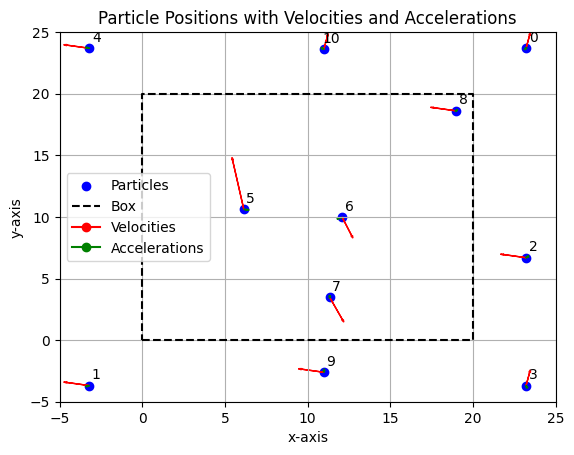

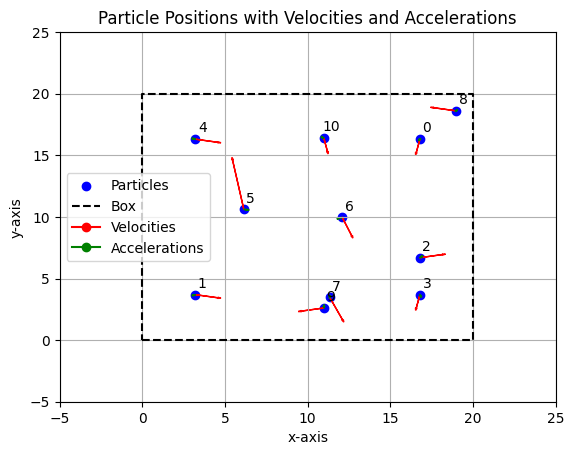

In [192]:
def test_reflection():
    sim_cons = Simulation_constants()
    sim_coarse = MD_simulation_lj_vv(
        sim_cons=sim_cons,
        pos_file="./test_init/reflect_pos.csv",
        vel_file="./test_init/reflect_vel.csv"
        )
    sim_coarse.step_reflect(debug=True,reflect_log=True)

test_reflection()

# Testing Force, Potential 

tmp: 
 tensor([[-0.0000e+00,  3.5611e+04, -3.0123e-02],
        [-0.0000e+00, -0.0000e+00, -8.3281e-02],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00]], dtype=torch.float64)
potential: 35610.82
v2: 
 [2. 2. 1.]
kinetic: 99.94
position:
     0    1
0  1.0  1.0
1  2.0  2.0
2  1.5  7.0
force:
           0          1
0 -214221.73 -214221.70
1  214221.72  214221.82
2       0.01      -0.12


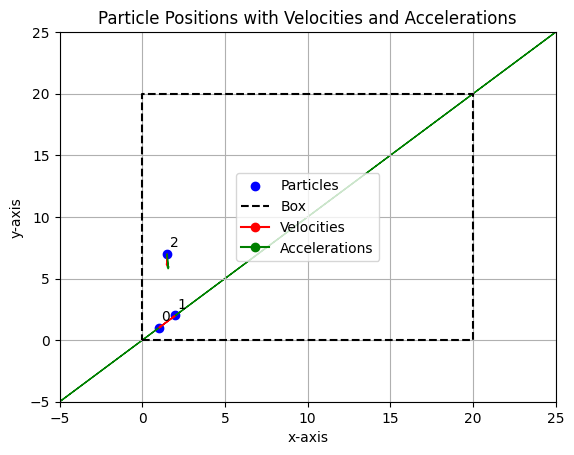

In [193]:
import pandas as pd
def test_force_etc():
    sim_cons = Simulation_constants()
    sim_coarse = MD_simulation_lj_vv(sim_cons, pos_file="./test_init/simple_pos.csv",vel_file="./test_init/simple_vel.csv")
    print(f"potential: {sim_coarse.get_potential_energy(positions=sim_coarse.positions,debug=True).detach().numpy():0.2f}")
    print(f"kinetic: {sim_coarse.get_kinetic_energy(debug=True).detach().numpy():0.2f}")
    print(f"position:\n{pd.DataFrame(sim_coarse.positions.detach().numpy()).round(2)}")
    print(f"force:\n{pd.DataFrame(sim_coarse.get_force().detach().numpy()).round(2)}")
    sim_coarse.plt_points()

test_force_etc()

In [194]:
import pandas as pd
def test_force2():
    sim_cons = Simulation_constants()
    sim_coarse = MD_simulation_lj_vv(sim_cons)
    print(f"potential: {sim_coarse.get_potential_energy(sim_coarse.positions).detach().numpy():0.2f}")
    print(f"force:\n{pd.DataFrame(sim_coarse.get_force().detach().numpy()).round(3)}")

    sim_gravity = MD_simulation_gravity_vv(sim_cons)
    print(f"potential: {sim_gravity.get_potential_energy(sim_gravity.positions).detach().numpy():0.2f}")
    print(f"force:\n{pd.DataFrame(sim_gravity.get_force().detach().numpy()).round(3)}")

test_force2()

potential: -2.53
force:
        0      1
0  -0.004  0.118
1  -0.075 -0.074
2   0.089 -0.052
3   0.003  0.165
4  -0.018 -0.077
5  -0.090  0.088
6  -0.012  0.049
7   0.015 -0.262
8   0.092  0.048
9   0.127  0.069
10 -0.061  0.070
11  0.069 -0.099
12 -0.121  0.104
13 -0.026 -0.068
14 -0.113 -0.041
15  0.128 -0.039
potential: 64.17
force:
      0    1
0  -0.0 -0.4
1  -0.0 -0.4
2  -0.0 -0.4
3  -0.0 -0.4
4  -0.0 -0.4
5  -0.0 -0.4
6  -0.0 -0.4
7  -0.0 -0.4
8  -0.0 -0.4
9  -0.0 -0.4
10 -0.0 -0.4
11 -0.0 -0.4
12 -0.0 -0.4
13 -0.0 -0.4
14 -0.0 -0.4
15 -0.0 -0.4


# Testing lj_vv simulation

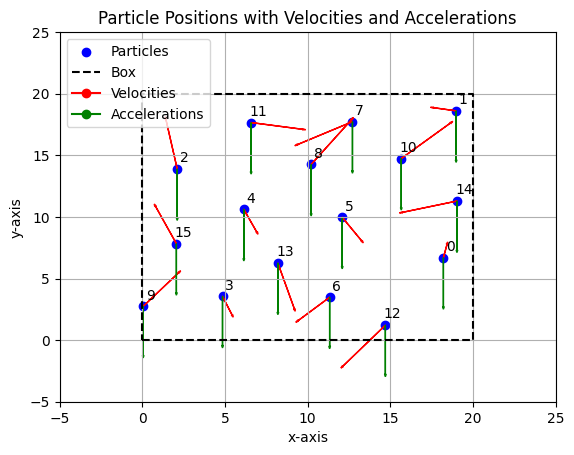

100


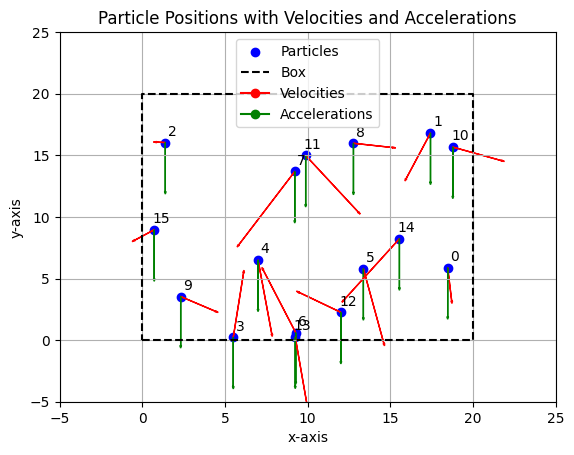

200


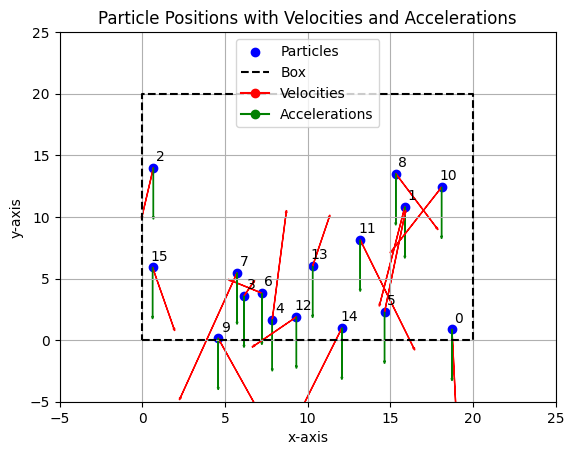

300


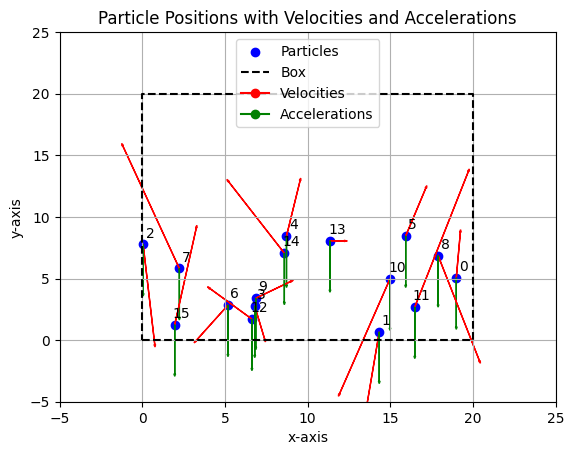

400


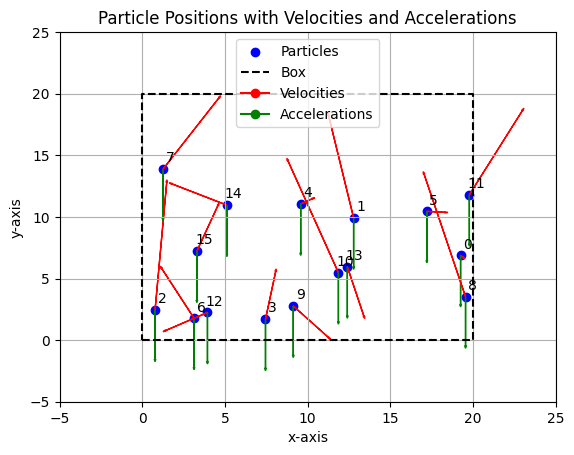

In [198]:
def test_sim_step(sim):
    sim.plt_points()
    for _ in range(400):
        sim.step(dt=0.01)
        if sim.total_steps%100 == 0:
            print(sim.total_steps)
            sim.plt_points()

sim_cons = Simulation_constants()
sim_lj = MD_simulation_lj_vv(sim_cons)
sim_gravity = MD_simulation_gravity_vv(sim_cons)
test_sim_step(sim_gravity)
# test_sim_step(sim_lj)

# Choosing dt
I estimate integration error by comparing to a finer simulation, in that way I estimate the size of contribution to the truncation error/ step of the integrator.

In [191]:
def get_convergence_error(dt):
    sim_cons = Simulation_constants()
    sim_coarse = MD_simulation_lj_vv(sim_cons) 
    sim_coarse.step(dt=dt)
    sim_fine = MD_simulation_lj_vv(sim_cons) 
    for _ in range(10):
        sim_fine.step(dt=dt/10,reflect_log=True)
    pos_error_per_step = (sim_fine.positions-sim_coarse.positions)/dt
    print(f"dt:{dt}, estimate pos_error_per_step :\n{pd.DataFrame(pos_error_per_step.detach().numpy()).round(5)}")

for dt in [0.5,0.25,0.1,0.01]:
    get_convergence_error(dt)

amount of reflections: 1
dt:0.5, estimate pos_error_per_step :
          0        1
0  -0.01346 -0.06966
1   0.53807  0.93041
2  -0.08922  0.05504
3  -0.08772 -0.13214
4  -0.04622 -0.01682
5   0.12498 -0.12874
6   0.89128 -0.95412
7   2.81305  4.92353
8  -3.08610 -4.61022
9   0.09323 -0.01672
10 -0.52247 -1.04998
11  0.21526 -0.01042
12  0.30233 -0.17188
13 -1.13299  1.17036
14  0.03169  0.12890
15 -0.03171  0.01877
dt:0.25, estimate pos_error_per_step :
          0        1
0  -0.00542  0.03903
1  -0.02744 -0.04417
2  -0.02815  0.01866
3   0.00253 -0.02902
4  -0.01719 -0.01242
5   0.03492 -0.04938
6   0.20688 -0.20474
7   1.39615  2.32367
8  -1.46726 -2.20758
9   0.02886 -0.00082
10  0.02359  0.00448
11  0.06918 -0.01848
12 -0.00493  0.00199
13 -0.20946  0.17624
14  0.00944 -0.01140
15 -0.01170  0.01394
dt:0.1, estimate pos_error_per_step :
          0        1
0  -0.00013  0.00768
1  -0.00474 -0.00725
2  -0.00540  0.00362
3   0.00154 -0.00553
4  -0.00295 -0.00316
5   0.00611 -0.00943